# Lensing by galaxy clusters

Galaxy clusters are the largest structures in the sky. They are dominated by dark matter. Being incredibly massive, they are very strong gravitational lenses. Gravitational lensing is caused by matter curving space time. When the light from a distant galaxies passes near a massive galaxy cluster, it gets deflected and the source appears distorted, like when we observe something through a piece of glass. 

<img src='./Gravitational-lensing-galaxyApril12_2010-1024x768.jpg' style='width: 50%'/>

By measuring the distortions of the images of the distant galaxies, we can invert the process of lensing and determine how the matter responsible for this effect is distributed. As said, the vast majority of this matter is dark.

<img src='./f7385a_43031cf41afe4858a462cdb2b2b0fdc1.png' style='width: 50%'/>

# A machine learning approach to identify the galaxies in the background of a galaxy cluster


One of the most important steps to extract the weak lensing signal of a galaxy cluster from astronomical data is to perform a clean separation between the galaxies in the cluster background and those belonging to the cluster itself or laying in its foreground. If these last galaxies are erroneously included in the sample of background sources, they will bias low the measurement of the lensing signal. This effect is commonly referred as "lensing dilution". Consequently, any information derived from lensing, like the mass of the gravitational lens, will be biased as well.

One of the most diffuse methods to separate the lensed from the unlensed galaxies relies on colors. Each galaxy spectro-morphological type can be associated to a typical spectral energy distribution (SED). Galaxies with the same SED but at different distances have different observed colors, because the expansion of the universe causes their SED to be redshifted differently. In addition, the vast majority of the galaxies in the clusters are red ellipticals, contrary to the galaxies in the field which are more frequently spiral or irregular galaxies where active star formation, and, thus, bluer colors.

<img src='./redshifting.png' style='width: 40%'/>
<img src='./apj327789f5_lr.jpg' style='width: 40%'/>

Methods employed so far to separate galaxies in color space require significant human interaction. The regions in color space occupied by the background galaxies are drawn trying to minimize the contamination by foreground galaxies and to maximize the yield of available sources for the lensing analysis. Often, conservative cuts are done to prevent the lensing dilution, thus decreasing the signal-to-noise. In any case, the procedure is hardly replicable by different users, beacause of the subjectiveness of the criteria adopted.

Here we attempt to optimize the color selection of galaxies for the weak lensing analysis by training several machine learning algorithms with training sets provided by state-of-the-art photometric and spectroscopic observations of cluster fields. We discuss the performance of each algorithm and identify the most informative features for such analysis.


## Spectroscopic catalog for MACS1206

The data used here are extracted from the CLASH-VLT spectroscopic catalog. This has been matched with the CLASH-Subaru catalog to combine photometric and spectroscopic measurements. The CLASH-Subaru catalog contains measurements of the source magnitudes (i.e. fluxes) in the B,V,R,I,Z bands, in addition to a source ID and to the source position on the sky (RA, DEC). The CLASH-VLT catalog contains source ids, positions, redshifts, and quality flags (i.e. an indication of how reliable is the redshift measurement), for a subsample of the galaxies in the CLASH-Subaru catalog.



Since these two features are in common among the two catalogs, the RA, DEC are used to match the sources in the two catalogs. ** In addition, the spectroscopic data have been cleaned already by removing all sources with a bad quality flag **.



In [1]:
# import the relevant packages
import numpy as np
import pandas as pd
import seaborn as sns

# read the matched catalog into a pandas dataframe and rename some of the columns. 
# prepare the catalog for the following analysis
df=pd.read_csv('matched.cat')
df.dropna(axis=1,inplace=True)
df.columns.values[0:7]=['name','ra','dec','z',' z QF','Reference','Kron R']

## Creating the features

With the data in our hands we can attempt to generate a larger number of features. Subsequently, we will try to figure out which one are the most informative.

First of all, using the photometric measurements in 5 bands, we can generate 10 independent colors. ** In astronomy a color is the difference between the magnitude in two bands. Since the magnitude is proportional to the -Log10 of the flux (i.e. the energy/area/time received from the emitting source), the color measures the Log10 of the ratio between the fluxes in two bands. **.

Other information may be contained in the position of the galaxies with respect to the brightest central galaxy in the cluster. This special galaxy is often assumed to be the center of the cluster. We expect the cluster members to be  clustered, while galaxies in the background or in the foreground to be randomly distributed.

Finally, since the background galaxies are farther than the cluster, we expect their apparent luminosity to be smaller than that of the foreground galaxies or of the cluster members. Thus, we use the magnitude in a reference band (R) as an additional feature.

In [2]:
def createFeatures(df,columns):
    # create new columns in the dataframe containing different colors which can be generated
    # using the available bands
    import numpy as np

    colors=[]
    for i in xrange(columns.size-1): 
        for j in xrange(i+1,columns.size):
            df[columns[i]+''+columns[j]] = df[columns[i]]-df[columns[j]]
            colors.append(columns[i]+''+columns[j])
    
    return np.array(colors)

def addDistanceFromCenter(df,center):
    # compute distances  of all galaxies from the cluster center
    ra=df['ra'].values
    dec=df['dec'].values
    print ra.shape,dec.shape
    x=-(ra-center[0])*(np.cos(center[1]/180.0*np.pi)*3600.0)
    y=(dec-center[1])*3600.0
    r=np.sqrt(x**2+y**2)
    df['dist']=r

cols=np.array(['B','V','R','I','Z'])
center=np.array([181.55063,-8.8009665])
colors=createFeatures(df,cols)

addDistanceFromCenter(df,center)

# some columns can be dropped:
df.drop('RA',1,inplace=True)
df.drop('Dec',1,inplace=True)
df.drop('Reference',1,inplace=True)
df.drop('X',1,inplace=True)
df.drop('Y',1,inplace=True)
df.drop(df.columns[8:18],1,inplace=True)


(2665,) (2665,)


## Examining the data

We give a look at the data we have to work with.

In [3]:
df.describe()

,ra,dec,z,z QF,Kron R,id,area,Separation,BV,BR,BI,BZ,VR,VI,VZ,RI,RZ,IZ,dist
count,2665.000000,2665.000000,2665.000000,2665.000000,2665.000000,2665.000000,2665.000000,2665.000000,2665.000000,2665.000000,2665.000000,2665.000000,2665.000000,2665.000000,2665.000000,2665.000000,2665.000000,2665.000000,2665.000000
mean,181.572053,-8.806062,0.496660,3.081426,22.250011,27580.377861,239.534334,0.034965,0.576999,1.142087,1.700248,1.794713,0.565089,1.123250,1.217714,0.558161,0.652626,0.094464,505.411312
std,0.121131,0.095611,0.340356,1.529653,1.195874,10849.661339,491.271864,0.041492,5.244630,4.717145,6.213617,4.753871,2.379163,4.694922,2.424105,4.042860,0.326553,4.034639,234.078185
min,181.271914,-9.002202,0.000000,2.000000,9.990000,6868.000000,9.000000,0.000540,-122.410700,-121.916200,-121.268500,-121.030300,-121.377900,-120.821700,-120.552200,-0.318100,-0.394800,-121.379500,0.181539
25%,181.483943,-8.882864,0.421400,2.000000,21.600000,19000.000000,88.000000,0.015402,0.457800,0.935000,1.194900,1.359400,0.410700,0.675400,0.851500,0.243100,0.403000,0.163200,333.439676
50%,181.572924,-8.806062,0.468700,3.000000,22.420000,27288.000000,145.000000,0.025048,0.650100,1.174100,1.549000,1.776900,0.612100,0.993600,1.199800,0.385500,0.612000,0.238800,512.723413
75%,181.668227,-8.736987,0.594700,3.000000,23.080000,34785.000000,249.000000,0.038736,0.979600,1.786200,2.332100,2.635900,0.810100,1.386600,1.678400,0.560700,0.844700,0.300700,676.164783
max,181.830928,-8.603561,3.982900,9.000000,25.400000,55639.000000,17275.000000,0.465199,122.468100,3.141300,122.960000,4.949800,1.297800,122.666700,3.440500,122.072700,2.481000,0.794100,1116.144988


We notice that the min and max values of some of the colors are extremely low or high with respect to the bulk of the values. Indeed, reasonable values of colors should be in the range $\sim 0-5$. However, some sources seem to have a bad photometry (or are un-detected) in some bands. We decide to clean the catalog by excluding these galaxies from the analysis.

We can now split the galaxies into three categories: foreground, cluster, and background sources. The cluster MACS1206 has a known redshift of $z=0.45$. We assume that the cluster galaxies have redshift $0.4<z<0.5$. Therefore, the foreground and the background galaxies meet the conditions $z<0.4$ and $z>0.5$ respectively.

The plot below gives us a hint of how the three classes are separated in color space and in the distance-magnitude space.

['BV' 'BR' 'BI' 'BZ' 'VR' 'VI' 'VZ' 'RI' 'RZ' 'IZ']


(18.5, 25)

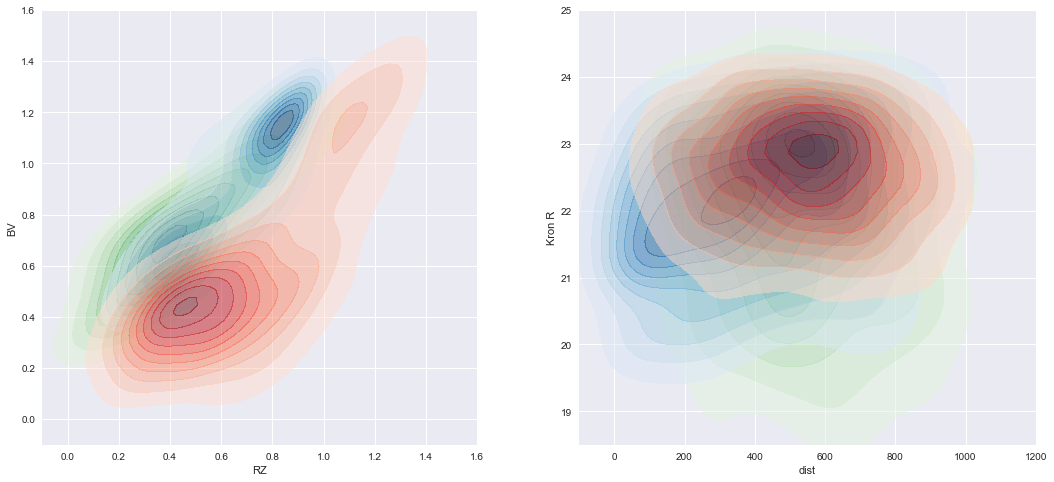

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
print colors
# getting rid of galaxies with anomalous colors
df_sel=df.loc[df['Kron R']<30]
for i in range(colors.size):
    df_sel=df_sel.query("(("+colors[i]+")>-10) & (("+colors[i]+")<10)")
    
# Subset the  dataset by species
foreground = df_sel.query("(z <= 0.4)")
cluster = df_sel.query("(z > 0.439-0.05) & (z<=0.439+0.05)")
background = df_sel.query("(z > 0.5)")

f, ax = plt.subplots(1,2,figsize=(18, 8))
ax[0].set_aspect("equal")
#ax[1].set_aspect("equal")

# Draw density plots
sns.kdeplot(foreground['RZ'], foreground['BV'],
            cmap="Greens", shade=True, shade_lowest=False,alpha=0.5,ax=ax[0])
sns.kdeplot(cluster['RZ'], cluster['BV'],
            cmap="Blues", shade=True, shade_lowest=False,alpha=0.5,ax=ax[0])
sns.kdeplot(background['RZ'], background['BV'],
            cmap="Reds", shade=True, shade_lowest=False,alpha=0.5,ax=ax[0])
ax[0].set_xlim([-0.1,1.6])
ax[0].set_ylim([-0.1,1.6])


sns.kdeplot(foreground['dist'], foreground['Kron R'],
            cmap="Greens", shade=True, shade_lowest=False,alpha=0.5,ax=ax[1])
sns.kdeplot(cluster['dist'], cluster['Kron R'],
            cmap="Blues", shade=True, shade_lowest=False,alpha=0.5,ax=ax[1])
sns.kdeplot(background['dist'], background['Kron R'],
            cmap="Reds", shade=True, shade_lowest=False,alpha=0.5,ax=ax[1])
ax[1].set_xlim([-100,1200])
ax[1].set_ylim([18.5,25])

While the separation between foreground and cluster members may be difficult, we may be able to separate these galaxies from the background sources. 

The sample of background galaxies approximately equals the number of foreground and cluster galaxies.

In [5]:
print background.index.size
print foreground.index.size
print cluster.index.size

1263
633
756


## Training and testing

We have used the data described above to train and validate several classifiers. Their performance is quantified in terms of accuracy and recall. We experimented with neural network models constructed with ```Keras``` as well as with other classifiers built with ```sklearn```.

To begin, we split the sample into  training and  test sets. The test set amounts to 20% of the total sample. Because the features have significantly different numerical values, we scale and normalize them using the function ```scale``` from the ```sklearn.prepocessing``` module.

In [6]:
import keras
X=np.zeros((df_sel.index.size,colors.size+2))
for i in range(colors.size):
    X[:,i]=df_sel[colors[i]]

X[:,colors.size]=df_sel['dist']
X[:,colors.size+1]=df_sel['Kron R']
#X[:,colors.size+2]=df_sel['z']

#X=np.zeros((df_sel.index.size,colors.size+2))
#for i in range(colors.size):
#    X[:,i]=df_sel[colors[i]]


from sklearn import preprocessing
X_scaled = preprocessing.scale(X)

from sklearn.feature_selection import SelectFromModel



# problem 1: use the features to separate background and foreground galaxies
df_sel['label'] = np.where(df_sel['z'] < 0.5, 0, 1)
#df_sel['label'] = np.where(((df_sel['z'] > 0.438-0.05) & (df_sel['z'] < 0.438+0.05)), 0, 1)
Y=df_sel['label'].values

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

y_train = keras.utils.to_categorical(Y_train, num_classes=2)
y_test = keras.utils.to_categorical(Y_test, num_classes=2)
y_all=keras.utils.to_categorical(Y, num_classes=2)

Using TensorFlow backend.


### Building a Sequential model withe Keras

To begin we use ```keras``` to build a deep learning model to classify the galaxies into background and foreground/cluster galaxies. The model is trained and validated with the sets defined above. We use the ```adam``` algorithm to optimize the learning rate and the categorical cross-entropy as loss function. The optimization is controlled by an early-stopping monitor.

The neural-network architecture consists of an input layer with 100 units, three hidden layers again with 100 units and an output layer with two units. The activation function of each node in the input and in hidden layers is the Rectified Linear Activation Function (relu) and the activation function for the output layer is the Softmax.

In [16]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD
# Import EarlyStopping
from keras.callbacks import EarlyStopping

model=Sequential()
model.add(Dense(100,activation='relu',input_shape=(X_train.shape[1],)))
model.add(Dense(100,activation='relu'))
model.add(Dense(100,activation='relu'))
model.add(Dense(100,activation='relu'))
model.add(Dense(2,activation='softmax'))
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

# Define early_stopping_monitor
early_stopping_monitor = EarlyStopping(patience=2)

# Fit the model
model_train=model.fit(X_train,y_train,epochs=30,validation_split=0.2,callbacks=[early_stopping_monitor])


#model.fit(X_train,y_train)
#model.fit(X_scaled,y_all,validation_split=0.3)
pred=model.predict_classes(X_test)

print ''
from sklearn.metrics import classification_report
target_names = ['Foreground', 'Background']
#target_names = ['Cluster members', 'Background/Foreground']
print(classification_report(Y_test, pred, target_names=target_names))

Train on 1700 samples, validate on 425 samples
Epoch 1/30
1700/1700 [==============================] - 0s - loss: 0.4300 - acc: 0.8347 - val_loss: 0.2736 - val_acc: 0.9129
Epoch 2/30
1700/1700 [==============================] - 0s - loss: 0.2710 - acc: 0.9071 - val_loss: 0.2339 - val_acc: 0.9176
Epoch 3/30
1700/1700 [==============================] - 0s - loss: 0.2466 - acc: 0.9147 - val_loss: 0.2142 - val_acc: 0.9388
Epoch 4/30
1700/1700 [==============================] - 0s - loss: 0.2288 - acc: 0.9241 - val_loss: 0.2072 - val_acc: 0.9341
Epoch 5/30
1700/1700 [==============================] - 0s - loss: 0.2047 - acc: 0.9329 - val_loss: 0.1926 - val_acc: 0.9271
Epoch 6/30
1700/1700 [==============================] - 0s - loss: 0.2000 - acc: 0.9329 - val_loss: 0.1926 - val_acc: 0.9318
Epoch 7/30
1700/1700 [==============================] - 0s - loss: 0.2071 - acc: 0.9259 - val_loss: 0.1952 - val_acc: 0.9365
Epoch 8/30
1700/1700 [==============================] - 0s - loss: 0.1854 - ac

The classifier seems to perform very well, reaching precision and recall of order $\sim 95\%$.

Other architectures with different numbers of layers and nodes have been considered and discarded because of the lower performance on the validation set. The model capacity has been tweeked using the validation loss as reference metric.

Train on 1700 samples, validate on 425 samples
Epoch 1/30
1700/1700 [==============================] - 0s - loss: 0.4121 - acc: 0.8388 - val_loss: 0.2787 - val_acc: 0.9082
Epoch 2/30
1700/1700 [==============================] - 0s - loss: 0.2959 - acc: 0.8918 - val_loss: 0.2427 - val_acc: 0.9200
Epoch 3/30
1700/1700 [==============================] - 0s - loss: 0.2524 - acc: 0.9171 - val_loss: 0.2328 - val_acc: 0.9224
Epoch 4/30
1700/1700 [==============================] - 0s - loss: 0.2234 - acc: 0.9288 - val_loss: 0.2221 - val_acc: 0.9271
Epoch 5/30
1700/1700 [==============================] - 0s - loss: 0.2123 - acc: 0.9288 - val_loss: 0.1939 - val_acc: 0.9435
Epoch 6/30
1700/1700 [==============================] - 0s - loss: 0.2023 - acc: 0.9329 - val_loss: 0.1758 - val_acc: 0.9506
Epoch 7/30
1700/1700 [==============================] - 0s - loss: 0.1976 - acc: 0.9347 - val_loss: 0.2018 - val_acc: 0.9365
Epoch 8/30
1700/1700 [==============================] - 0s - loss: 0.1938 - ac

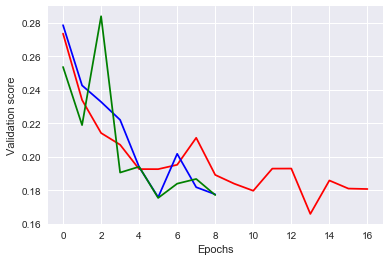

In [17]:
model_alt=Sequential()
model_alt.add(Dense(200,activation='relu',input_shape=(X_train.shape[1],)))
model_alt.add(Dense(200,activation='relu'))
model_alt.add(Dense(200,activation='relu'))
model_alt.add(Dense(2,activation='softmax'))
model_alt.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

model_alt1=Sequential()
model_alt1.add(Dense(200,activation='relu',input_shape=(X_train.shape[1],)))
model_alt1.add(Dense(200,activation='relu'))
model_alt1.add(Dense(200,activation='relu'))
model_alt1.add(Dense(200,activation='relu'))
model_alt1.add(Dense(2,activation='softmax'))
model_alt1.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

# Define early_stopping_monitor
early_stopping_monitor = EarlyStopping(patience=2)

# Fit the model
model_train_alt=model_alt.fit(X_train,y_train,epochs=30,validation_split=0.2,
                                callbacks=[early_stopping_monitor])

model_train_alt1=model_alt1.fit(X_train,y_train,epochs=30,validation_split=0.2,
                                callbacks=[early_stopping_monitor])

# Plot the validation loss
plt.plot(model_train.history['val_loss'], 'r',model_train_alt.history['val_loss'], 'b',
         model_train_alt1.history['val_loss'], 'g')
plt.xlabel('Epochs')
plt.ylabel('Validation score')
plt.show()

## Other classifiers

Using ```sklearn```, it is easy to implement other classifiers to compare to the multi-layer perceptron discussed above.

### Naive bayes
The first classifier we test here is the Gaussian Naive Bayes classifier. It uses the Bayes rule to compute the probability that one object belongs to a class assuming that the likelihood of the features is  Gaussian. The algorithm is used in many applications of text classification, but, in principle it should work here too.

In [9]:
from sklearn.naive_bayes import GaussianNB
clf_nb=GaussianNB()
clf_nb.fit(X_train,Y_train)

pred=clf_nb.predict(X_test)

from sklearn.metrics import accuracy_score

acc=accuracy_score(pred,Y_test)
print acc

0.842105263158


In [10]:
from sklearn.metrics import classification_report
#target_names = ['Foreground', 'Background']
target_names = ['Cluster members', 'Background/Foreground']
print(classification_report(Y_test, pred, target_names=target_names))

                       precision    recall  f1-score   support

      Cluster members       0.90      0.80      0.85       292
Background/Foreground       0.79      0.89      0.84       240

          avg / total       0.85      0.84      0.84       532



This classifier has a worse performance compared to the MLP. Precision and recall are $\sim 85\%$. The major limitation of this algorithm is given by the assumption of gaussianity of the features, which might not be good.

### Support Vector Machine

Another very popular algorithm for classification is the Support Vector Machine algorithm. In support vector machine we try to define the boundaries between classes by maximizing the distance of the data from the boundary themselves (margin). The algorithm can be used also in cases where the classes are not linearly separable. This is done by creating new features that are non-linear transformations of the features themselves. More generally  this operation can be done using the so-called "kernel trick". A kernel function is used to map the existing features into a larger feature space. There are several kind of kernels that one could use, including RBF, sigmoid, polynomial, etc. 

There are two parameters that define how the algorithm works. The first is called the "C" parameter. This parameter controls the trade-off between smooth decision boundaries and classifying training points correctly. The second is the "$\gamma$" parameter, which defines how far the influence of a single training example reaches.

In this analysis, we use a RBF kernel. We select the best parameters $C$ and $\gamma$ by performing a grid search with cross validation.

In [11]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV
g=np.logspace(-3,3,12)
c=np.logspace(-3,3,12)
parameters = {'gamma':g,'C':c}
svr = svm.SVC()
clf = GridSearchCV(svr, parameters)
clf.fit(X_train, Y_train)

print clf.best_score_
print  clf.best_estimator_.C
print  clf.best_estimator_.gamma

from sklearn import svm
# build a support vector classifier
clf_svc = svm.SVC(C=clf.best_estimator_.C,gamma=clf.best_estimator_.gamma,kernel='rbf') # gamma=1.0/2.0/sigma^2 
clf_svc.fit(X_train,Y_train)
pred=clf_svc.predict(X_test)

from sklearn.metrics import accuracy_score

acc=accuracy_score(pred,Y_test)
print acc

0.932705882353
1.87381742286
0.0432876128108
0.93045112782


We can create a classification report:

In [12]:
from sklearn.metrics import classification_report
target_names = ['Foreground', 'Background']
#target_names = ['Cluster members', 'Background/Foreground']
print(classification_report(Y_test, pred, target_names=target_names))

             precision    recall  f1-score   support

 Foreground       0.94      0.93      0.94       292
 Background       0.91      0.93      0.92       240

avg / total       0.93      0.93      0.93       532



This shows that the performance of the SVM classifier is nearly identical to that of the MLP.

### Random forest classifier

Finally, we build and test a Random Forest Classifier. This classifier combines several decision trees to perform classification. Each tree is constructed from a bootstrapped sample of the training set. The predictive accuracy is improved by averaging the decisions. This also controls over-fitting. The classifier depends on several parameters. In this test we consider just the number of estimators (e.g. of decision trees), which will be combined. Again, we optimize the model by means of gridsearch with cross-validation.

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
n=np.arange(1,100,1,dtype=int)

parameters = {'n_estimators':n}
clf_=RandomForestClassifier()
clf = GridSearchCV(clf_, parameters)
clf.fit(X_train, Y_train)

print clf.best_score_
print  clf.best_estimator_.n_estimators

clf_rfc=RandomForestClassifier(n_estimators=clf.best_estimator_.n_estimators)
clf_rfc.fit(X_train,Y_train)
pred=clf_rfc.predict(X_test)
acc=accuracy_score(pred,Y_test)
print acc

0.931764705882
25
0.932330827068


In [14]:
print(classification_report(Y_test, pred, target_names=target_names))

             precision    recall  f1-score   support

 Foreground       0.94      0.93      0.94       292
 Background       0.92      0.93      0.93       240

avg / total       0.93      0.93      0.93       532



# Testing the feature importance

This last part of the work is an attempt to identify the most informative features among those available. To do that we use the Recursive Feature Elimitation method with the random forest classifier.

In [15]:
my_features=[colors[0:colors.size],'dist','mag']
from sklearn.feature_selection import RFE


for n_feat in range(2,X.shape[1]):
    rfe = RFE(clf_rfc, n_feat)
    rfe = rfe.fit(X_train, Y_train)
    print(rfe.support_)
    print(rfe.ranking_)
    pred=rfe.predict(X_test)
    acc=accuracy_score(pred,Y_test)
    print acc
print my_features

[ True False False False False  True False False False False False False]
[ 1  4  9  7  3  1  5  2  6  8 11 10]
0.890977443609
[ True False False False False  True False  True False False False False]
[ 1  2  5  8  3  1  6  1  4  7 10  9]
0.915413533835
[ True  True False False False  True False  True False False False False]
[1 1 3 7 2 1 5 1 4 6 9 8]
0.919172932331
[ True  True False False False  True  True False  True False False False]
[1 1 3 6 2 1 1 4 1 5 8 7]
0.928571428571
[ True  True False False  True  True False  True  True False False False]
[1 1 4 5 1 1 3 1 1 2 7 6]
0.934210526316
[ True  True  True False  True  True False  True  True False False False]
[1 1 1 3 1 1 2 1 1 5 6 4]
0.928571428571
[ True  True False False  True  True  True  True  True  True False False]
[1 1 3 2 1 1 1 1 1 1 5 4]
0.934210526316
[ True  True  True False  True  True  True  True  True  True False False]
[1 1 1 2 1 1 1 1 1 1 4 3]
0.928571428571
[ True  True  True  True  True  True  True  True  True  

It looks like that most of the information is contained in the colors, rather than into the distance or the observed luminosity. The reason is that 

* the distance may be useful to separate the cluster members from the foreground and the background galaxies. However, when the foreground and the cluster galaxies are mixed together, the feature becomes uninformative;
* the observed luminosity (magnitude) is also not very helpful to separate the foreground and the baground galaxies.

# Next steps

We may seek further improvements by either adding the size of the galaxies as a further constraint or the entire image of the each galaxy. In fact, morphological informations such as size, star forming regions, structure of the spiral arms etc. may contain information to separate the background from the foreground galaxies.

It may be possible that separating the cluster members from the background and foreground galaxies  results in an easier separation successive separation of background and foreground objects. 

# Conclusions

In this exercise, we tested several machine learning algorithms to identify the galaxies in the background of the cluster MACS1206. The training, testing, and validation was performed using the matched catalog of sources with meausured photometry and redshifts from the CLASH-VLT and the CLASH-Subaru collaborations.

Among the classification algorithms employed here, three have simular performances. The goal of the analysis is to produce a catalog of galaxies usable for a weak lensing analysis. The primary requirement for such catalog is an high level of purity. Therefore, among the metrics usable to quantify the performance of each classifier, the precision of the classification of the background sample is the most important. Secondly, an high recall guaranties that enough galaxies are available to perform an high-resolution mapping of the matter within the cluster. Given the results, the best algorithm to perform the required tasks is the random forest classifier.

The model can now be applied to MACS1206 and to clusters at similar distance to us. For example, MACSJ0416 is an ideal system for applying the model.